In [176]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random

In [2]:
# Load S1 dataset
dataset = pd.read_csv('../dataset/APDPk-S1.csv', names=['x','y'],sep=r'\s*,\s*',na_values="?",engine='python')
dataset.tail()

,x,y
4995,665048,854911
4996,210497,359835
4997,366794,582584
4998,608309,377530
4999,335121,214149


In [5]:
# Normalization dataset to [0,1]
def normalization(list):
    dataset=np.array(list)
    min_max_scaler=preprocessing.MinMaxScaler()

    normaldataset=min_max_scaler.fit_transform(dataset)
    return normaldataset

data = normalization(dataset)
print(data)

[[0.69308026 0.86133085]
 [0.16919891 0.57184644]
 [0.42787512 0.81894665]
 ...
 [0.36827631 0.57790645]
 [0.62463009 0.35493321]
 [0.3346573  0.17727468]]


In [224]:
class APDPkmeans():
    def __init__(self, data, n_clusters, flag = "normal", dimensional = 2, eps = 10, iters_max = 10):
        self.data = data
        self.n_sample, _ = data.shape
        self.dimensional = dimensional
        self.sensitivity = self.dimensional + 1
        self.k = n_clusters
        self.totaleps = eps
        self.iters = iters_max
        self.initial_centers = self.init_center()
        self.flag = flag
        
    def l2_distance(self, datapoint):
        dists = np.sqrt(np.sum((self.centers - datapoint)**2, axis=1))
        return dists
    
    def init_center(self):
        block=int(self.n_sample/self.k)
        x = 0
        list=np.zeros((self.k,self.data.shape[1]))
        for i in range(self.k):
            list[i:]=self.data[x]
            x=x+block
        center_array=list
        return center_array
    
    def mineps(self, k, N, d):
        minepslion=np.sqrt(((500*k**3)/N**2)*np.power((d+(4*d*0.45**2)**(1/3)),3))
        result=round(minepslion,3)
        return result

    def generate_eps(self):
        mineps = self.mineps(self.k, self.n_sample, self.dimensional)
        t = int(self.totaleps/mineps)
        if t > self.iters:
            d = (2*self.totaleps-2*mineps*self.iters)/(self.iters*(self.iters-1))
            eps = np.zeros(self.iters)
            for n in range(self.iters):
                e = mineps+n*d
                eps[n] = e
            self.eacheps = eps[::-1]
            print("iters: ", self.iters)
            print("AP: ", eps[::-1])
        else:
            if self.flag == "new":
                self.iters = t
                eps = np.full(self.iters, mineps)
            else:
                eps = np.full(self.iters, self.totaleps / self.iters)
            print("iters: ", self.iters)
            print("Uniform: ", eps)
            self.eacheps = eps

    def classify(self, datapoint):
        """
        Given a datapoint, compute the cluster closest to the
        datapoint. Return the cluster ID of that cluster.
        """
        dists = self.l2_distance(datapoint)
        return np.argmin(dists)

    # laplace_array
    def laplacenoise_array(sensitivity,epslion,len,num):  #  产生laplace噪声数组,len是维数，num是生成的个数
        location=0
        scale=sensitivity/epslion
        list=[]
        for i in range(num):
            list .append( np.random.laplace(location, scale, len))
            Laplacian_noise=np.array(list)
        return Laplacian_noise
            
    def SSE(self):
        sse = 0
        
    
    def fit(self):
        self.centers = np.copy(self.initial_centers)
        self.sse = []
        self.generate_eps()
        old_assigns = None
        old_sse = np.inf
        n_iters = 0
        
        while True:
            new_assigns = [self.classify(datapoint) for datapoint in self.data]
            
            if new_assigns == old_assigns or n_iters == self.iters:
                print(f"Training finished after {n_iters} iterations!")
                self.end_iter = n_iters
                return
                
            old_assigns = new_assigns
            epsilon = self.eacheps[n_iters]
            n_iters += 1
            sse = 0
            laplace_num = np.random.laplace(0, self.sensitivity / epsilon, self.k)
            laplace_sumx = np.random.laplace(0, self.sensitivity / epsilon, self.k)
            laplace_sumy = np.random.laplace(0, self.sensitivity / epsilon, self.k)
            centers = np.copy(self.centers)
            
            print(f"---------------------------------\n{n_iters} iter: eps = ", epsilon)
            
            # recalculate centers
            for id_ in range(self.k):
                points_idx = np.where(np.array(new_assigns) == id_)
                datapoints = data[points_idx]
                num = datapoints.size / 2 + laplace_num[id_]
                sumpoints = datapoints.sum(axis = 0) + np.array([laplace_sumx[id_], laplace_sumy[id_]])
                centers[id_] = sumpoints / num
                sse += np.sqrt(np.sum((centers[id_] - datapoints)**2, axis=1)).sum()
            
            self.centers = np.copy(centers)
            print("sse: ", sse)
            self.sse.append(sse)
                
                
    def plot_clusters(self):
        plt.figure(figsize=(12,10))
        plt.title("APDPk-means cluster")
        plt.scatter(data[:, 0], data[:, 1], marker='.', c=[self.classify(datapoint) for datapoint in self.data])
        plt.scatter(self.centers[:, 0], self.centers[:,1], c='r')
        plt.plot()
        
        sse_x_label = range(self.end_iter)
        plt.figure(figsize=(12,10))
        plt.title("APDPk-means sse")
        plt.plot(sse_x_label, self.sse, marker='o')
        plt.show()
        
        

In [197]:
class KMeans():
    def __init__(self, n_clusters=15):
        self.k = n_clusters
 
    def fit(self, data):
        """
        Fits the k-means model to the given dataset
        """
        n_samples, _ = data.shape
        # initialize cluster centers
        self.centers = np.array(random.sample(list(data), self.k))
        self.initial_centers = np.copy(self.centers)
 
        # We will keep track of whether the assignment of data points
        # to the clusters has changed. If it stops changing, we are 
        # done fitting the model
        old_assigns = None
        n_iters = 0
 
        while True:
            new_assigns = [self.classify(datapoint) for datapoint in data]
 
            if new_assigns == old_assigns:
                print(f"Training finished after {n_iters} iterations!")
                return
 
            old_assigns = new_assigns
            n_iters += 1
 
            # recalculate centers
            for id_ in range(self.k):
                points_idx = np.where(np.array(new_assigns) == id_)
                datapoints = data[points_idx]
                self.centers[id_] = datapoints.mean(axis=0)
 
    def l2_distance(self, datapoint):
        dists = np.sqrt(np.sum((self.centers - datapoint)**2, axis=1))
        return dists
 
    def classify(self, datapoint):
        """
        Given a datapoint, compute the cluster closest to the
        datapoint. Return the cluster ID of that cluster.
        """
        dists = self.l2_distance(datapoint)
        return np.argmin(dists)
 
    def plot_clusters(self, data):
        plt.figure(figsize=(12,10))
        plt.title("K-means")
        plt.scatter(data[:, 0], data[:, 1], marker='.', c=[self.classify(datapoint) for datapoint in data])
        plt.scatter(self.centers[:, 0], self.centers[:,1], c='r')
        plt.show()



iters:  10
Uniform:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
---------------------------------
1 iter: eps =  1.0
sse:  483.1294303896919
---------------------------------
2 iter: eps =  1.0
sse:  405.011929242903
---------------------------------
3 iter: eps =  1.0
sse:  349.24886615346037
---------------------------------
4 iter: eps =  1.0
sse:  291.15391972632733
---------------------------------
5 iter: eps =  1.0
sse:  248.18212802282474
---------------------------------
6 iter: eps =  1.0
sse:  256.4831832580448
---------------------------------
7 iter: eps =  1.0
sse:  240.52089740833708
---------------------------------
8 iter: eps =  1.0
sse:  241.96467952706269
---------------------------------
9 iter: eps =  1.0
sse:  258.0158894336313
---------------------------------
10 iter: eps =  1.0
sse:  257.19338105418353
Training finished after 10 iterations!


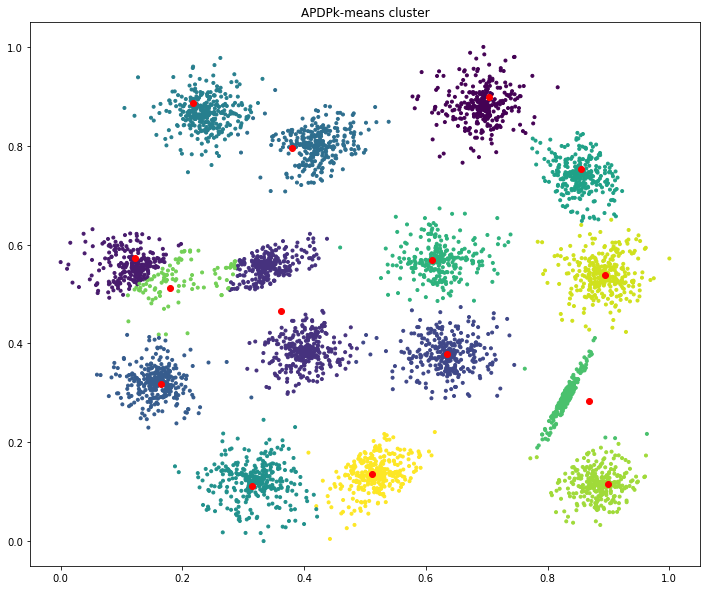

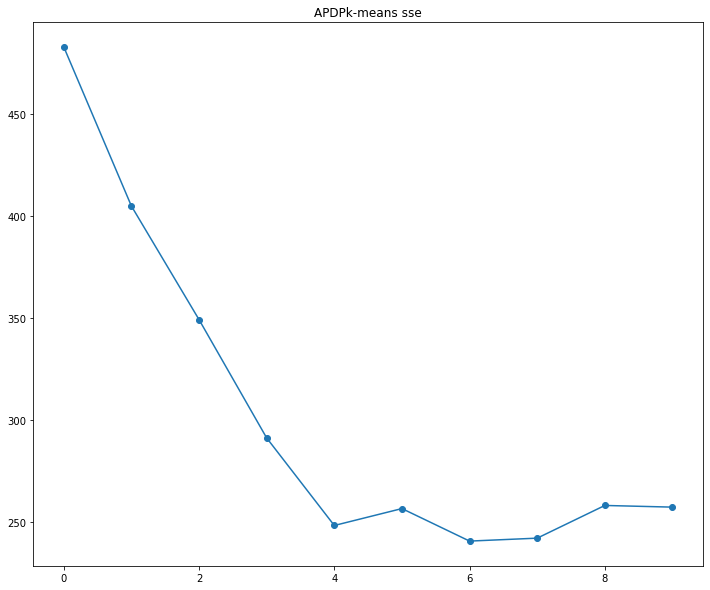

In [225]:
apdpkmeans = APDPkmeans(data, n_clusters = 15)
apdpkmeans.fit()
apdpkmeans.plot_clusters()

iters:  6
Uniform:  [1.469 1.469 1.469 1.469 1.469 1.469]
---------------------------------
1 iter: eps =  1.469
sse:  473.52725453331306
---------------------------------
2 iter: eps =  1.469
sse:  378.51652611380644
---------------------------------
3 iter: eps =  1.469
sse:  314.0388320297747
---------------------------------
4 iter: eps =  1.469
sse:  267.30792612900126
---------------------------------
5 iter: eps =  1.469
sse:  247.67017474361077
---------------------------------
6 iter: eps =  1.469
sse:  236.6660895806051
Training finished after 6 iterations!


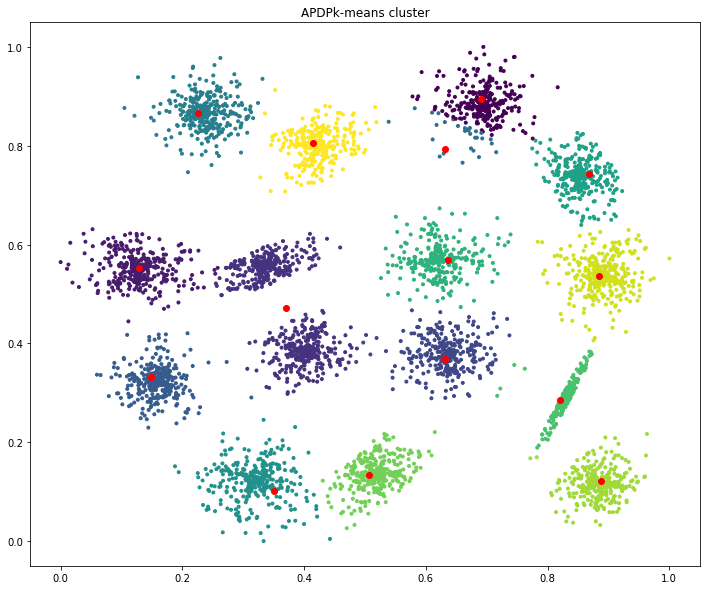

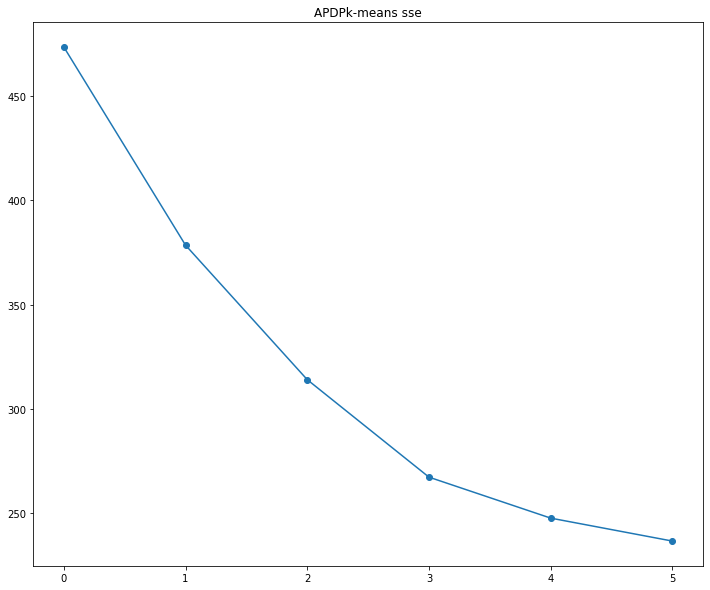

In [226]:
apdpkmeans = APDPkmeans(data, n_clusters = 15, flag = "new")
apdpkmeans.fit()
apdpkmeans.plot_clusters()

Training finished after 20 iterations!


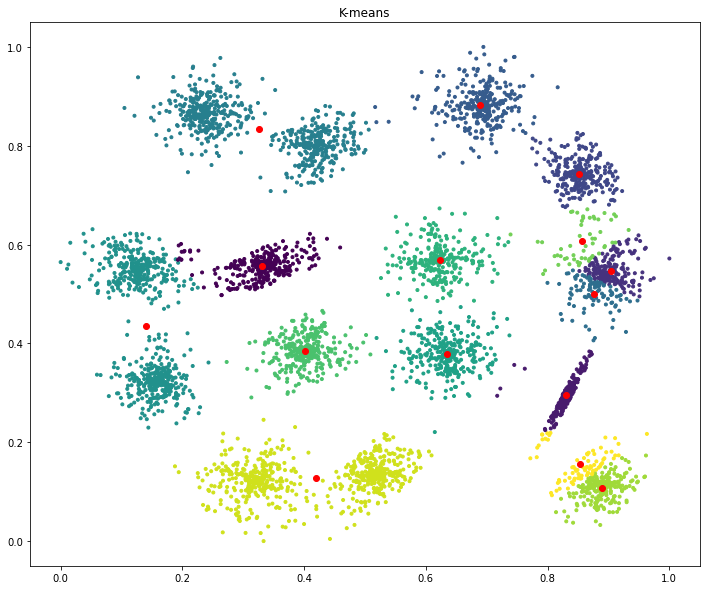

In [199]:
kmeans = KMeans()
kmeans.fit(data)
kmeans.plot_clusters(data)